# Transferlearning

<div style="padding: 5px; border: 5px solid #a10000ff;">

**Hinweis:** In den Codezellen sind jeweils einige Codeteile nicht programmiert. Diesen Code müssen Sie ergänzen. Die jeweiligen Stellen sind mit einem Kommentar und dem Keyword **TODO** vermerkt und z.T. Stellen mit ... markiert.

Ausserdem gibt es einige assert Statements. Diese geben einen Fehler aus, sollte etwas bei Ihrer Programmierung nicht korrekt sein.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import os
import random
import PIL.Image as Image


## Hintergrundinformationen zu Transfer Learning

### Torch vorbereiten

In [2]:
# Wir prüfen ob eine Hardwarebeschleunigung möglich ist und verwenden diese, wenn sie verfügbar ist
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
torch.manual_seed(42) # Setze den Zufallsseed für Reproduzierbarkeit
print(f"Using {device} device")

Using cpu device


## FER-2013 Dataset vorbereiten, laden und visualisieren

Das FER-2013 Dataset enthält Bilder von Gesichtern, die in verschiedene Emotionen klassifiziert sind. Es ist ein häufig verwendetes Dataset für die Gesichtsemotionserkennung. 
In diesem Abschnitt werden wir das Dataset vorbereiten, laden und einige Beispiele visualisieren.

### Daten laden

In [3]:
data_path = "datasets/FER-2013/"
data_train_path = os.path.join(data_path, "train")
data_test_path = os.path.join(data_path, "test")

In [ ]:
train_images = torch.load(os.path.join(data_train_path, "train_images.pt"))
train_labels = torch.load(os.path.join(data_train_path, "train_labels.pt"))
test_images = torch.load(os.path.join(data_test_path, "test_images.pt"))
test_labels = torch.load(os.path.join(data_test_path, "test_labels.pt"))


label_mapping = {
    'angry': 0,
    'disgust': 1,
    'fear': 2,
    'happy': 3,
    'sad': 4,
    'surprise': 5,
    'neutral': 6
}

reverse_label_mapping = {v: k for k, v in label_mapping.items()}


### Beispielbilder aus dem FER-2013 Dataset visualisieren

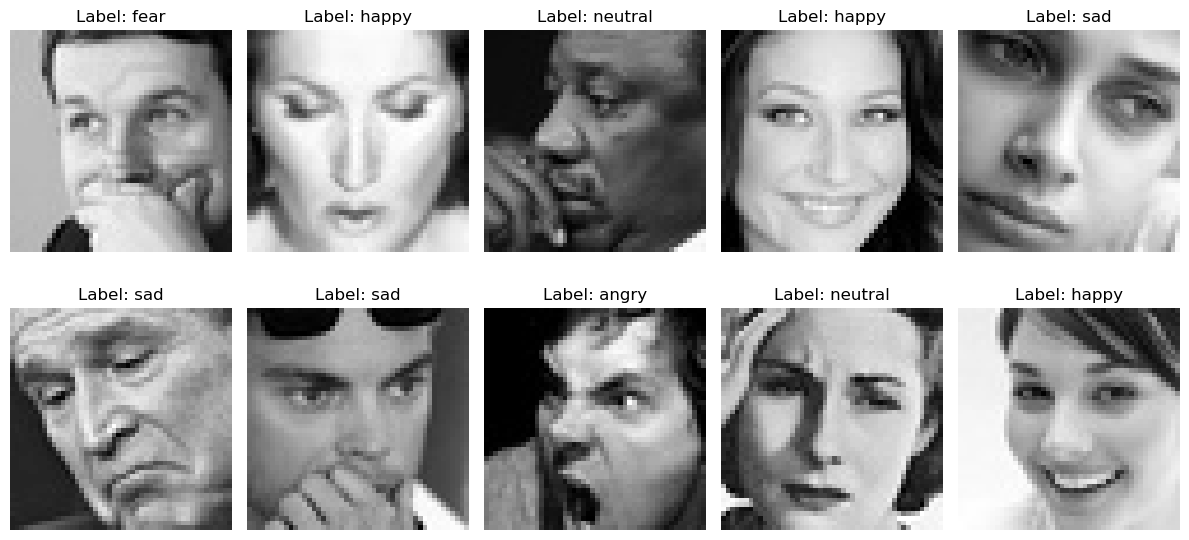

In [5]:
# 10 Beispiele plotten
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    random_index = random.randint(0, len(train_images) - 1)
    ax = axes[i // 5, i % 5]
    ax.imshow(train_images[random_index].squeeze(), cmap='gray')
    ax.set_title(f"Label: {reverse_label_mapping[train_labels[random_index].item()]}")
    ax.axis('off')
plt.tight_layout()
plt.show()


### Daten validieren

Damit wir die Daten benutzen können, müssen alle Daten gleich formiert sein. Das heisst alle Bilder müssen die gleiche Grösse haben und die Pixelwerte müssen im gleichen Bereich liegen.

In diesem Abschnitt prüfen wir, ob es verschiedene Bildgrössen gibt, ob alle Pixelwerte von 0 bis 255 reichen und zeigen ein Beispiel eines Bildes an.

In [ ]:
# Die Anzahl Trainings- und Testdaten anzeigen
print(f"Anzahl Trainingsbilder: {len(train_images)}")
print(f"Anzahl Testbilder: {len(test_images)}")

# Prüfe ob alle Bilder die gleiche Grösse haben. Die Bilder sind als Tensoren gespeichert, daher können wir die Form der Tensoren überprüfen.
image_shapes = [image.shape for image in train_images]
unique_shapes = set(image_shapes)
print(f"Einzigartige Bildgrössen: {unique_shapes}")


Anzahl Trainingsbilder: 28709
Anzahl Testbilder: 7178
Einzigartige Bildgrößen: {torch.Size([1, 48, 48])}


### Weitere Validierungsschritte

Auch weitere Validierungsschritte sollten durchgeführt werden.

- Sind die Klassen einigermassen gleich verteilt?
- Gibt es fehlende Werte (z.B. auch leere Bilder)?
- Sind auf allen Bildern tatsächlich Gesichter zu sehen?
- Sind die Ausschnitte der Bilder sinnvoll und ähnlich (z.B. alle Bilder zeigen das Gesicht von vorne, oder gibt es auch Bilder von der Seite)?

#### Prüfen der Pixelwerte und Labels

In [7]:
# Prüfen, dass die Pixelwerte im Bereich von 0 bis 255 liegen. Die Bilder sind als Tensoren gespeichert.
# Wir prüfen die Pixelwerte für alle Bilder, indem wir die Werte der Tensoren extrahieren und in eine flache Liste umwandeln.
temp_train_images_np = train_images.numpy()
assert np.all(temp_train_images_np >= 0) and np.all(temp_train_images_np <= 255)

# Labels prüfen
labels = [label.item() for label in train_labels]
print(f"Einzigartige Labels: {set(labels)}")

Einzigartige Labels: {0, 1, 2, 3, 4, 5, 6}


### Data Loader erstellen

In diesem Abschnitt erstellen wir einen Data Loader, um die Daten in Batches zu laden und für das Training vorzubereiten. 
Die Daten sind in Trainings- und Testset aufgeteilt.

In [8]:
# Da die Bilder in einem eigenen Format vorliegen, normalisieren wir die Pixelwerte manuell, indem wir die Pixelwerte durch 255 teilen, um sie in den Bereich von 0 bis 1 zu bringen. Dies ist wichtig, damit das Training stabiler und schneller lernt.

# Wir müssen hier die Bilder normalisieren, da die Pixelwerte im Bereich 0 bis 255 liegen. Wir teilen die Pixelwerte dementsprechend durch 255.
train_images_tensors = train_images.float() / 255.0
test_images_tensors = test_images.float() / 255.0

# Data Loader erstellen
train_loader = DataLoader(list(zip(train_images_tensors, train_labels)), batch_size=64, shuffle=True)
test_loader = DataLoader(list(zip(test_images_tensors, test_labels)), batch_size=64, shuffle=False)


## Transfer Learning mit einem vortrainierten Modell

### Einführung in Transfer Learning mit ResNet

Transfer Learning ist eine Technik, bei der wir ein Modell, das bereits auf einem grossen Dataset (wie ImageNet) trainiert wurde, nutzen und es für eine neue Aufgabe (wie Gesichtsemotionserkennung) anpassen. Das hat mehrere Vorteile:

1. **Schnelleres Training**: Das Modell muss nicht von Grund auf neu trainiert werden
2. **Bessere Leistung**: Die gelernten Features vom ursprünglichen Modell sind oft sehr nützlich
3. **Weniger Daten erforderlich**: Transferlearning funktioniert gut auch mit kleineren Datasets

Wir werden:
1. Ein vortrainiertes ResNet-Modell laden
2. Es für unsere Aufgabe (7 Emotionsklassen) anpassen
3. Das Modell trainieren
4. Die Ergebnisse evaluieren

### Schritt 1: ResNet-Modell laden

In [ ]:
from torchvision import models
import torch.nn as nn

# Lade ResNet-18 mit vortrainierten Gewichten aus ImageNet
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

print("ResNet-18 Modell geladen!")
print(f"Anzahl der Parameter: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainierbare Parameter: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

### Schritt 2: Das Modell modifizieren für unsere Aufgabe

ResNet-18 wurde ursprünglich für ImageNet trainiert, die 1000 Klassen hat. Wir brauchen aber nur 7 Klasssen für unsere Emotionen. Daher müssen wir den letzten Layer (die Ausgabeschicht) austauschen.

Im FER-2013 Dataset gibt es sieben Emotionsklassen, die vorhergesagt werden sollen.

In [ ]:
# Wir müssen die Eingabeschicht auch modifizieren, weil ResNet 3 Kanäle (RGB) erwartet
# aber unsere Bilder sind Graustufenbilder mit 1 Kanal
# Daher erstellen wir eine neue erste Schicht

# Speichern Sie das ursprüngliche erste Conv-Layer
original_conv = model.conv1

# Ersetzen Sie den ersten Conv-Layer mit einem neuen Layer, der 1 Kanal akzeptiert
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Kopiere die neutrainierten Gewichte vom ursprünglichen Layer (nehme den Durchschnitt über die RGB-Kanäle)
with torch.no_grad():
    model.conv1.weight = nn.Parameter(original_conv.weight.mean(dim=1, keepdim=True))

print("Erste Schicht modifiziert: 1 Kanal (Graustufenwerte) statt 3 Kanäle (RGB)")

# Ersetze die Ausgabeschicht (fc - fully connected) mit einer neuen für 7 Klassen
num_ftrs = model.fc.in_features  # Dies sollte 512 sein für ResNet-18
model.fc = nn.Linear(num_ftrs, 7)  # 7 Emotionsklassen

print(f"Ausgabeschicht modifiziert: {num_ftrs} inputs -> 7 outputs (Emotionsklassen)")
print("\nModifiziertes Modell:")
print(model)

### Kontrollfrage 3: Warum müssen wir die erste Schicht modifizieren?

**Frage:** 
- Warum haben wir die erste Schicht (conv1) modifiziert?
- ResNet erwartet 3 Eingangskanäle - was sind diese Kanäle bei einem RGB-Bild?
- Unsere Eingabe hat nur 1 Kanal - was bedeutet das?
- Wie lösen wir dieses Problem und warum funktioniert das?

### Antwort zu Kontrollfrage 3

**Warum die erste Schicht modifizieren?**

ResNet-18 wurde mit RGB-Bildern trainiert, die 3 Farbkanäle haben:
- R (Rot)
- G (Grün)
- B (Blau)

Die erste Convolution Layer erwartet daher 3 Eingabekanäle.

**Unsere Bilder:**  
Die FER-2013-Daten sind **Graustufenbilder** mit nur **1 Kanal**. Ein Graustufenbild speichert nur die Helligkeit jedes Pixels, nicht die Farbrausch.

**Die Lösung:**
Wir ersetzen das ursprüngliche Conv2d-Layer durch eines mit 1 statt 3 Eingabekanälen:
```python
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
```

**Warum funktioniert das?**
- Wir kopieren die Gewichte des ursprünglichen Layers und berechnen den Durchschnitt über die 3 RGB-Kanäle
- Dies ermöglicht Transfer Learning auch mit unterschiedlichen Eingabeformaten
- Die schon gelernten tiefen Features können weiterhin genutzt werden
- Die unterschiedliche die Eingabe (1 statt 3 Kanäle) könnte initial leicht anders reagieren, aber das Netzwerk passt sich schnell an

### Schritt 3: Modell auf GPU verschieben

In [ ]:
# Verschiebe das Modell auf die gleiche Vorrichtung wie wir vorher eingestellt haben
model = model.to(device)

print(f"Modell auf {device} verschoben")

### Schritt 4: Loss-Funktion und Optimizer definieren

Für ein Klassifizierungsproblem mit mehreren Klassen verwenden wir:
- **Loss-Funktion**: `CrossEntropyLoss` (kombiniert LogSoftmax und NLLLoss)
- **Optimizer**: `Adam` oder `SGD` mit Momentum

Für Transfer Learning empfehlen wir oft eine **kleinere Learning Rate**, da die Gewichte bereits gut trainiert sind.

In [ ]:
# Definiere Loss-Funktion und Optimizer
criterion = nn.CrossEntropyLoss()

# Für Transfer Learning verwenden wir eine kleinere Learning Rate
# 0.001 ist eine gute Starklasse für Fine-Tuning
learning_rate = 0.001

# Adam Optimizer mit Weight Decay (L2 Regularisierung)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# Optional: Learning Rate Scheduler, um die Learning Rate während des Trainings zu reduzieren
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

print(f"Loss-Funktion: CrossEntropyLoss")
print(f"Optimizer: Adam mit Learning Rate = {learning_rate}")
print(f"Scheduler: StepLR (reduziere LR um 10% alle 5 Epochen)")

### Kontrollfrage 4: Warum verwenden wir eine kleinere Learning Rate beim Transfer Learning?

**Frage:** 
Warum ist es wichtig, eine kleinere Learning Rate (z.B. 0.001) statt einer grösseren (z.B. 0.01) beim Transfer Learning zu verwenden? Was könnte passieren, wenn we eine zu hohe Learning Rate verwenden?

### Antwort zu Kontrollfrage 4

**Warum eine kleinere Learning Rate?**

Die vortrainierten Gewichte in ResNet sind **bereits gut optimiert** für Feature-Erkennung auf naturalen Bildern. Wenn wir eine zu hohe Learning Rate verwenden:

1. **Gewichte zerstören**: Grosse Updates könnten die gut gelernten Features zerstören und die Gewichte ruinieren
2. **Instabiles Training**: Das Netzwerk könnte divergieren statt zu konvergieren
3. **Katastrophales Vergessen**: Das Modell könnte die nützlichen Features "vergessen", die es auf ImageNet gelernt hat

**Bessere Strategie:**
```
- Learning Rate für neue Schichten (z.B. fc): 0.001 (oder höher)
- Learning Rate für vortrainierte Schichten: 0.0001 (oder 10x niedriger)
```

**Praktisches Beispiel:**
Mit einer grossen LR von 0.1 könnte jeder Update einen Schritt von 10-20% ändern. Das sind zu grosse Schritte!
Mit einer kleinen LR von 0.001 sind Updates von 0.1-0.2%, was vorsichtig und stabil ist.

**Zusätzliche Technik - Learning Rate Scheduling:**
Wir reduzieren die Learning Rate während des Trainings (z.B. alle 5 Epochen um 10%), damit das Modell feiner tunen kann.

### Schritt 5: Training einrichten

In [ ]:
# Trainingsfunktion
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Trainiert das Modell für eine Epoche"""
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in dataloader:
        # Verschiebe Data auf Device
        images = images.to(device)
        labels = labels.to(device)
        
        # Reshape für CNN: (batch_size, 1, 48, 48)
        if images.dim() == 3:
            images = images.unsqueeze(1)
        
        # Forward Pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward Pass und Optimierung
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Statistiken
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy


def evaluate(model, dataloader, criterion, device):
    """Evaluiert das Modell auf dem Test-Set"""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            # Verschiebe Data auf Device
            images = images.to(device)
            labels = labels.to(device)
            
            # Reshape für CNN
            if images.dim() == 3:
                images = images.unsqueeze(1)
            
            # Forward Pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Statistiken
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy

print("Trainingsfunktionen definiert!")

### Schritt 6: Modell trainieren

In [ ]:
import time

# Trainingskonfiguration
num_epochs = 20
best_accuracy = 0.0
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

print(f"Starte Training für {num_epochs} Epochen...")
print(f"Device: {device}\n")

start_time = time.time()

for epoch in range(num_epochs):
    # Training
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Evaluation
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    
    # Learning Rate Scheduler Update
    scheduler.step()
    
    # Speichere die Historien
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    # Speichere das beste Modell
    if test_acc > best_accuracy:
        best_accuracy = test_acc
        best_model_state = model.state_dict().copy()
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}% *** BEST ***")
    else:
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

training_time = time.time() - start_time

print(f"\nTraining abgeschlossen!")
print(f"Gesamte Trainingszeit: {training_time:.2f} Sekunden ({training_time/60:.2f} Minuten)")
print(f"Beste Testgenauigkeit: {best_accuracy:.2f}%")

# Lade das beste Modell
model.load_state_dict(best_model_state)

# Speichere das trainierte Modell
torch.save(model.state_dict(), 'FER_resnet18_transferred.pth')
print("Modell gespeichert als 'FER_resnet18_transferred.pth'")

### Schritt 7: Training-Verlauf visualisieren

In [ ]:
# Visualisiere den Training-Verlauf
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss Kurve
ax1.plot(train_losses, label='Training Loss', linewidth=2)
ax1.plot(test_losses, label='Test Loss', linewidth=2)
ax1.set_xlabel('Epoche')
ax1.set_ylabel('Loss')
ax1.set_title('Training- und Test-Loss über die Zeit')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy Kurve
ax2.plot(train_accuracies, label='Training Accuracy', linewidth=2)
ax2.plot(test_accuracies, label='Test Accuracy', linewidth=2)
ax2.axhline(y=best_accuracy, color='r', linestyle='--', label=f'Best Test Acc: {best_accuracy:.2f}%')
ax2.set_xlabel('Epoche')
ax2.set_ylabel('Genauigkeit (%)')
ax2.set_title('Training- und Test-Accuracy über die Zeit')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Drucke zusammenfassung
print("\n=== TRAINING ZUSAMMENFASSUNG ===")
print(f"Beste Test-Genauigkeit: {best_accuracy:.2f}%")
print(f"Finale Training-Genauigkeit: {train_accuracies[-1]:.2f}%")
print(f"Finale Test-Genauigkeit: {test_accuracies[-1]:.2f}%")
print(f"Training Loss reduziert um: {((train_losses[0] - train_losses[-1]) / train_losses[0] * 100):.1f}%")

### Kontrollfrage 5: Overfitting-Analyse

**Frage:** 
Schauen Sie sich die beiden Kurven an (Training Loss vs Test Loss, Training Accuracy vs Test Accuracy):
- Gibt es Anzeichen von Overfitting?
- Wenn ja, wo beginnt das Overfitting und wie würden Sie es bekämpfen?
- Welche Techniken könnten helfen? (Denken Sie an: Early Stopping, Dropout, Daten-Augmentation, L1/L2 Regularisierung)

### Antwort zu Kontrollfrage 5

**Overfitting-Analyse:**

Overfitting erkennen wir daran, dass:
- Die **Train Loss weiterhin sinkt** (das Modell lernt)
- Die **Test Loss aber ansteigt oder stagniert** (das Modell generalisiert nicht mehr)
- Es entsteht eine **Lücke zwischen Training und Test Accuracy**

**Techniken zur Vorbeugung:**

1. **Early Stopping**: Stoppe das Training, wenn Test Loss nicht mehr verbessert wird
2. **Dropout**: Deaktiviert zufällig Neuronen während des Trainings → verhindert komplexe Co-Adaptationen
3. **L2 Regularisierung** (Weight Decay): Bestraft grosse Gewichte (wir nutzen bereits `weight_decay=1e-4`)
4. **Daten-Augmentation**: Transformiert die Eingabebilder (Rotation, Verschiebung, Spiegelung) → äquivalent zu mehr Daten
5. **Batch Normalization**: Normalisiert Layer-Eingaben → stabilisiert Training
6. **Learning Rate Reduction**: Verringert LR wenn Validierung nicht verbessert → feinere Anpassungen

**In unserem Fall:**
Mit Transfer Learning ist Overfitting weniger problematisch, da die vortrainierten Gewichte bereits Regularisierung haben.
Die grösste Verbesserung bringt **Early Stopping** oder **Daten-Augmentation**.